# Nothing But NumPy: A 2-layer Binary Classification Neural Network on Iris Flowers

Part of the blog ["Nothing but NumPy: Understanding & Creating Binary Classification Neural Networks with Computational Graphs from Scratch"](https://medium.com/@rafayak/nothing-but-numpy-understanding-creating-binary-classification-neural-networks-with-e746423c8d5c)- by [Rafay Khan](https://twitter.com/RafayAK)

In this notebook we'll create a 2-layer neural network (i.e. one input and one output layer) and train it on the eintire Iris dataset to classify **Iris-virginica vs. others**

First, let's import NumPy, our neural net Layers, the Binary Cross-Entropy(bce) Cost function and helper functions.

_Feel free to look into the helper functions in the utils directory._

In [1]:
import numpy as np
from Layers.LinearLayer import LinearLayer
from Layers.ActivationLayer import SigmoidLayer
from util.utilities import *
from util.cost_functions import compute_stable_bce_cost
import matplotlib.pyplot as plt

# to show all the generated plots inline in the notebook
%matplotlib inline

![](imgs/verg_vs_other.png)

For convenience we'll load the data through [scikit-learn](https://scikit-learn.org/stable/index.html#). 

_If you don't have it installed please refer to this [link](https://scikit-learn.org/stable/install.html)_

In [2]:
# load data from scikit-learn's datasets module
from sklearn.datasets import load_iris

iris = load_iris()  # returns a python dictionary with the dataset

Let's see what the dataset contains:

In [3]:
list(iris.keys())

['data', 'target', 'target_names', 'DESCR', 'feature_names', 'filename']

- **data**: contains the 4 features of each example in a row, has 150 rows
- **target**: contains the label for each example _(0->setosa, 1->versicolor, 2->virginica)_
- **target_names**: contains the names of each target label
- **DESCR**: contains the desription of the dataset
- **feature_names**: contains the names of the 4 features(sepal length, sepal width, petal length, petal width)
- **filename** : where the file is located on the computer


Let's explore the data:

In [4]:
iris.data.shape  # rows(examples), cols(features)

(150, 4)

In [5]:
iris.target.shape # labels for 150 flowers 

(150,)

In [6]:
iris.target_names  # print the name of the 3 labels(species) an example could belong to

array(['setosa', 'versicolor', 'virginica'],
      dtype='<U10')

In [7]:
iris.feature_names  # name of each feature in data's columns

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

In [8]:
iris.data[:5, :]  # print first 5 examples from the Iris dataset

array([[ 5.1,  3.5,  1.4,  0.2],
       [ 4.9,  3. ,  1.4,  0.2],
       [ 4.7,  3.2,  1.3,  0.2],
       [ 4.6,  3.1,  1.5,  0.2],
       [ 5. ,  3.6,  1.4,  0.2]])

In [9]:
iris.target[:5]  # print labels for the first 5 examples in the Iris dataset

array([0, 0, 0, 0, 0])

So, the data of the **first** 5 examples looks as follows:

| exmaple# | sepal length (cm) | sepal width (cm) | petal length (cm) | petal width (cm) | target | target name|
| --- | --- | --- || --- | --- | --- |
| 0 | 5.1 | 3.5 | 1.4 |  0.2| 0|  setosa
| 1 |4.9|  3. |  1.4|  0.2|0|  setosa
| 2 |4.7|  3.2|  1.3|  0.2|0|  setosa
| 3 |4.6|  3.1|  1.5|  0.2|0|  setosa
| 4 |5. |  3.6|  1.4|  0.2|0|  setosa

We need to fix the shape of the target array as a precaution so that it's shape matches the input data

In [10]:
# X(input) will be entire training data
X = iris.data 

# fix the labes shape so that instead of (150,) its (150,1),
# helps avoiding weird broadcasting errors
Y = (iris.target).reshape((150, 1))  

In [11]:
X.shape

(150, 4)

In [12]:
Y.shape

(150, 1)

**Notice** in the table above that the first 5 examples belong to __'setosa'__ species, this pattern continues in the dataset(the pattern is all _setosa_ examples followed by _versicolor_ examples and finally _virginica_ examples). ___A good practice is to randomize the data before training a neural network, so that the neural network does not, by accident, learn a trivial ordering pattern in the data.___

So let's randomize the data

In [13]:
np.random.seed(48)  # for reproducible randomization 
random_indices = np.random.permutation(len(X))  # genrate random permutation of indices

X_train = X[random_indices]
Y_train = Y[random_indices]

Now let's again print the first 5 examples and see the results(note this time features are only two - petal lenght, petal width )

In [14]:
X_train[:5, :]

array([[ 5.7,  2.9,  4.2,  1.3],
       [ 6.1,  2.8,  4.7,  1.2],
       [ 6.1,  2.6,  5.6,  1.4],
       [ 4.5,  2.3,  1.3,  0.3],
       [ 5.9,  3.2,  4.8,  1.8]])

In [15]:
Y_train[:5]

array([[1],
       [1],
       [2],
       [0],
       [1]])

Now, the data of the **first** 5 examples looks as follows:

| exmaple# | sepal length (cm) | sepal width (cm) | petal length (cm) | petal width (cm) | target | target name|
| --- | --- | --- || --- | --- | --- |
| 0 | 5.7|  2.9|  4.2|  1.3| 1|  versicolor
| 1 | 6.1|  2.8|  4.7|  1.2|1|  versicolor
| 2 |6.1 |  2.6|  5.6|  1.4|2|  virginica
| 3 |4.5 |  2.3|  1.3|  0.3|0|  setosa
| 4 | 5.9|  3.2|  4.8|  1.8|1|  versicolor


Finally, let's put training set(`X_train`)  & and labels(`Y_train`) in the correct shape `(feat, examples)` and  `(examples,1)`, respectively. Also we'll make the target label ___virginica=1___ and the rest ___0___.  

In [16]:
# Transpose the data so that it's in the correct shape 
# for passing through neural network
# also binarize the classes viginica=1 and the rest 0
X_train = X_train.T
Y_train = Y_train.T  
Y_train = (Y_train==2).astype('int')  # uses bool logic  to binarize labels, wherever label=2 output True(1) rest Flase(0)           

In [17]:
print("Shape of training data, X_train: {}".format(X_train.shape))
print("Shape of  labels, Y_train: {}".format(Y_train.shape))

Shape of training data, X_train: (4, 150)
Shape of  labels, Y_train: (1, 150)


In [18]:
Y_train[:, :5]  # print first five examples

array([[0, 0, 1, 0, 0]])

Since the number of features are 4 in this dataset we cannot visuallize it on a 2-D plot😒 

***
***

#### Now we are ready to setup and train the Neural Network

This is the neural net architecture we'll use

![](imgs/4in_2_layer_NN.png)

In [19]:
# define training constants
learning_rate = 0.3
number_of_epochs = 5000

np.random.seed(48) # set seed value so that the results are reproduceable
                  # (weights will now be initailzaed to the same pseudo-random numbers, each time)


# Our network architecture has the shape: 
#                   (input)--> [Linear->Sigmoid] -> [Linear->Sigmoid] -->(output)  

#------ LAYER-1 ----- define hidden layer that takes in training data 
Z1 = LinearLayer(input_shape=X_train.shape, n_out=3, ini_type='xavier')
A1 = SigmoidLayer(Z1.Z.shape)

#------ LAYER-2 ----- define output layer that takes in values from hidden layer
Z2= LinearLayer(input_shape=A1.A.shape, n_out= 1, ini_type='xavier')
A2= SigmoidLayer(Z2.Z.shape)

Now we can start the training loop:

In [20]:
costs = [] # initially empty list, this will store all the costs after a certian number of epochs

# Start training
for epoch in range(number_of_epochs):
    
    # ------------------------- forward-prop -------------------------
    Z1.forward(X_train)
    A1.forward(Z1.Z)
    
    Z2.forward(A1.A)
    A2.forward(Z2.Z)
    
    # ---------------------- Compute Cost ----------------------------
    cost, dZ2 = compute_stable_bce_cost(Y=Y_train, Z=Z2.Z)
    
    # print and store Costs every 100 iterations and of the last iteration.
    if (epoch % 100) == 0:
        print("Cost at epoch#{}: {}".format(epoch, cost))
        costs.append(cost)
    
    # ------------------------- back-prop ----------------------------
    
    Z2.backward(dZ2)
    
    A1.backward(Z2.dA_prev)
    Z1.backward(A1.dZ)
    
    # ----------------------- Update weights and bias ----------------
    Z2.update_params(learning_rate=learning_rate)
    Z1.update_params(learning_rate=learning_rate)

Cost at epoch#0: 0.5842834152498868
Cost at epoch#100: 0.36310976755875046
Cost at epoch#200: 0.2312121547146245
Cost at epoch#300: 0.20815465292508076
Cost at epoch#400: 0.15236070381583322
Cost at epoch#500: 0.12396740039354323
Cost at epoch#600: 0.10787788203569885
Cost at epoch#700: 0.09750860915431853
Cost at epoch#800: 0.09028448866093153
Cost at epoch#900: 0.08497225692281726
Cost at epoch#1000: 0.08090311871991471
Cost at epoch#1100: 0.07768356139449455
Cost at epoch#1200: 0.07506790890045067
Cost at epoch#1300: 0.07289557330707988
Cost at epoch#1400: 0.07105762631932071
Cost at epoch#1500: 0.06947787956085147
Cost at epoch#1600: 0.06810164192309977
Cost at epoch#1700: 0.06688876399133185
Cost at epoch#1800: 0.06580918596634044
Cost at epoch#1900: 0.06484000390592067
Cost at epoch#2000: 0.06396348719044047
Cost at epoch#2100: 0.06316570898725746
Cost at epoch#2200: 0.06243558167500952
Cost at epoch#2300: 0.06176416575211792
Cost at epoch#2400: 0.06114416711531772
Cost at epoch#

Now let's see how well the neural net peforms on the training data after the training as finished

`predict` helper functionin the cell below returns three things:

* `p`: predicted labels (output 1 if predictded output is greater than classification threshold `thresh`)
* `probas`: raw probabilities (how sure the neural net thinks the output is 1, this is just `P_hat`)
* `accuracy`: the number of correct predictions from total predictions



In [21]:
classifcation_thresh = 0.5


predicted_outputs, p_hat, accuracy = predict(X=X_train, Y=Y_train, 
                                             Zs=[Z1, Z2], As=[A1, A2], thresh=classifcation_thresh)

print("The predicted outputs of first 5 examples: \n{}".format(predicted_outputs[:,:5]))
print("The predicted prbabilities of first 5 examples:\n {}".format(np.round(p_hat[:, :5], decimals=3)) )
print("\nThe accuracy of the model is: {}%".format(accuracy))

The predicted outputs of first 5 examples: 
[[ 0.  0.  1.  0.  0.]]
The predicted prbabilities of first 5 examples:
 [[ 0.001  0.002  0.981  0.001  0.407]]

The accuracy of the model is: 98.66666666666666%


#### The Learning Curve

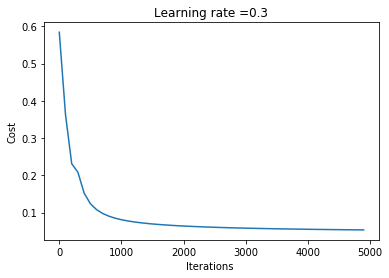

In [22]:
plot_learning_curve(costs, learning_rate, total_epochs=number_of_epochs)

## Bounus 

Try different learning rates. See the effect on learning curve. 

_(Hint: if the learning curve is not smooth and very erratic then Gradient Descent is bouncing around the minimum point, all because the learnig rate is too high.)_